# Multivariable regression
#### Emile Badran U2 L4 P4

Using the [2013 FBI:UCR Crime dataset](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls), **build a regression model to predict property crimes**. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.3f}'.format
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Loading the data, fixing column names, and filling NANs:

In [2]:
data = pd.read_excel('fbi_ny_2013.xls', sheet_name=0, header=1, skiprows=3, skip_footer=3,
                     index_col=0, thousands=None)

data.columns = ['population', 'violent_crime',
       'murder','rape', 'rape_legacy',
       'robbery', 'assault', 'property_crime', 'burglary',
       'larceny_theft', 'vehicle_theft', 'arson']
data.index.names = ['city']
data = data.fillna(0)
data = data.astype('int64')

### Convert data to rates per 1000 inhabitants and filter violent crime variables

The variable **'property_crime'** is equal to the sum of **'burglary', 'larceny_theft', 'vehicle_theft', 'arson'**. So none of the four variables can be used in this challenge.

In [3]:
df = data[['population','property_crime','rape_legacy','murder','assault','robbery']]

for i in df.iloc[:,1:].columns:
    df[i] = (df[i] / df['population'])*1000
df.head(n=5)

,population,property_crime,rape_legacy,murder,assault,robbery
city,,,,,,
Adams Village,1861,6.448,0.000,0.000,0.000,0.000
Addison Town and Village,2577,9.313,0.000,0.000,1.164,0.000
Akron Village,2846,5.622,0.000,0.000,1.054,0.000
Albany,97956,41.753,0.306,0.082,5.370,2.317
Albion Village,6388,34.909,0.470,0.000,2.505,0.626


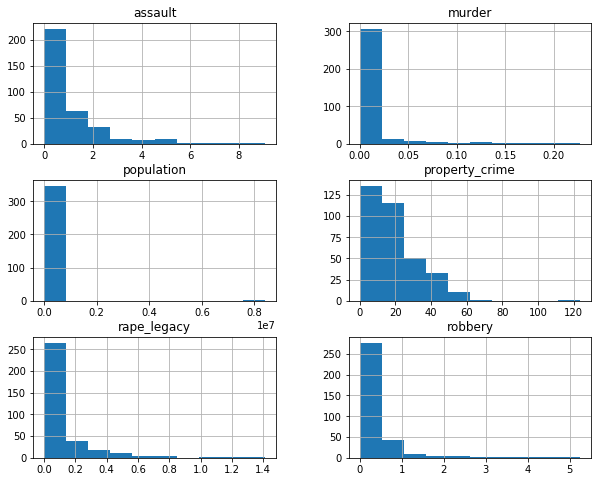

In [4]:
df.hist(figsize = (10,8))
plt.show()

### Transform all variables to a more normal distribution:

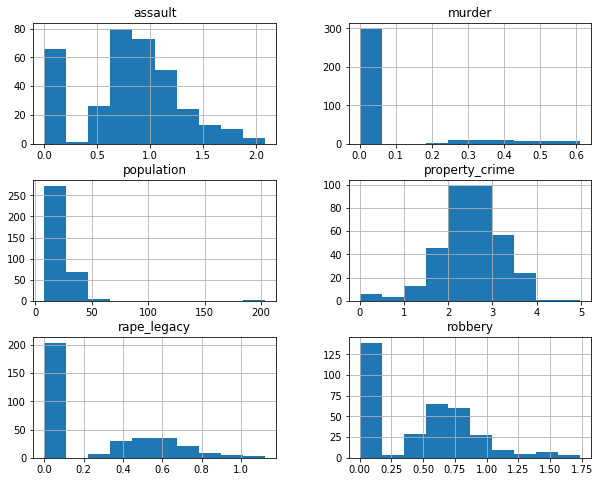

In [5]:
df = np.cbrt(df)
df.hist(figsize = (10,8))
plt.show()

### Inspecting the correlations between variables and property crime:

Murder has a low correlation to property_crime and won't be included in the PCA.

In [6]:
df.corr()

,population,property_crime,rape_legacy,murder,assault,robbery
population,1.000,0.183,0.327,0.415,0.311,0.490
property_crime,0.183,1.000,0.476,0.232,0.577,0.563
rape_legacy,0.327,0.476,1.000,0.364,0.492,0.527
murder,0.415,0.232,0.364,1.000,0.384,0.490
assault,0.311,0.577,0.492,0.384,1.000,0.551
robbery,0.490,0.563,0.527,0.490,0.551,1.000


### Principal Component Analysis:

In [7]:
# Since variable correlation is relatively low, and the dataset is small, 
# three components will be used:
sklearn_pca = PCA(n_components=3)

# Murder has a low correlation to property_crime and won't be included:
Y_sklearn = sklearn_pca.fit_transform(df[['rape_legacy','assault','robbery']])
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.70978772  0.1824105   0.10780178]


### Regression with PCA's Y-component:


Coefficients: 
 [ 0.78858832 -0.08387417  0.0747047 ]

Intercept: 
 2.50811513256

R-squared:
0.435027725031


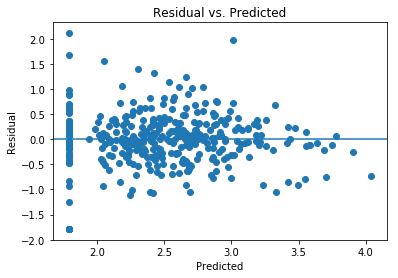

In [8]:
# X is the dimensionally reduced component resulting from PCA:
X = Y_sklearn

# property_crime is the variable that we want to predict:
Y = df['property_crime']

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X, Y)

predicted = regr.predict(X).ravel()
actual = Y

residual = actual - predicted

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Testing the predictions with holdout (60 / 40):

#### Running the regression with 60% training data:


Coefficients: 
 [ 0.76718136 -0.12320305  0.07333545]

Intercept: 
 2.50402261974

R-squared:
0.42846809245


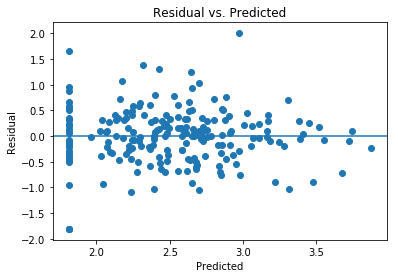

In [9]:
# property_crime is the variable that we want to predict:
Y = df['property_crime']
# X is the dimensionally reduced component resulting from PCA:
X = Y_sklearn

# Test the model with different holdout groups with sklearn:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=20)

regr.fit(X_train, y_train)

predicted = regr.predict(X_train).ravel()
actual = y_train

residual = actual - predicted

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_train, y_train))

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#### Running the regression with 40% testing data:


Coefficients: 
 [ 0.82358616 -0.01572927  0.0853743 ]

Intercept: 
 2.51404047752

R-squared:
0.446700455176


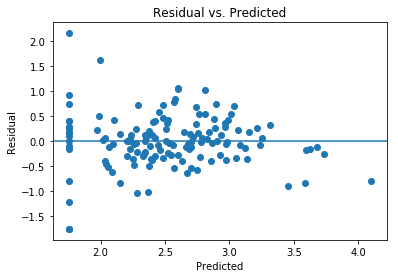

In [10]:
regr.fit(X_test, y_test)

predicted = regr.predict(X_test).ravel()
actual = y_test

residual = actual - predicted

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test, y_test))

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Cross-validate:
The results aren't great.

In [11]:
regr = regr.fit(X, Y)
cross_val_score(regr, X, Y, cv=10)

array([ 0.56312076,  0.53948204,  0.24085313,  0.39337736,  0.41969007,
        0.43333538,  0.42900481,  0.2488038 ,  0.45283558,  0.30241235])